In [1]:
from rattle_newton.sim_snake_tb import ThermalSimulator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import math
import matplotlib.dates as mdates

In [26]:
## Simulate a Year
# Set the starting date and time
start_time = datetime(year=2023, month=1, day=1, hour=0, minute=0)
time_step = 30
# Set the time interval every 15 minutes
time_interval = timedelta(minutes=time_step)

# Set the number of intervals in a day
intervals_per_day = 24 * 60 // time_step

# Set the number of days in a year
days_in_year = 365*2

time_series=[]
# Simulate a whole year
current_time = start_time
for day in range(days_in_year):
    for interval in range(intervals_per_day):
        time_series.append(current_time.strftime('%Y-%m-%d %H:%M:%S'))
        current_time += time_interval
        

In [41]:
## Simulate environmental conditions
# Parameters
amplitude = (40 - 10) / 2  # 40 degrees c
offset = (40 + 10) / 2  # 10 degrees c

# Time values 
_time = np.arange(0, len(time_series))

## Outside Temp
# simulated with a sin function with that oscilates between 40 degrees and 10
outside_temp = amplitude * np.sin(2 * np.pi * _time / 360) + offset 

## Burrow Temp
# constant 20 degrees
burrow_temp = [15 for t in _time]

In [27]:
max(outside_temp)

40.0

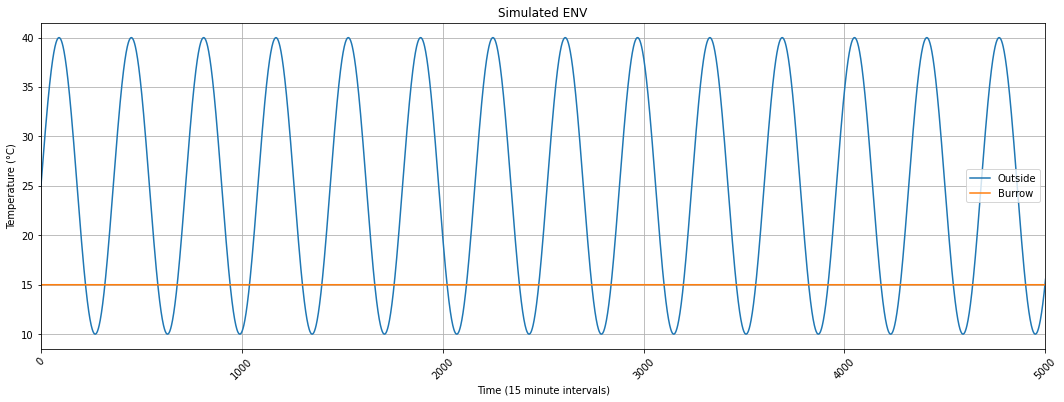

In [42]:
plt.figure(figsize=(18, 6))
plt.plot(_time, outside_temp,label='Outside')
plt.plot(_time, burrow_temp,label='Burrow')
plt.title('Simulated ENV')
plt.xlabel('Time (15 minute intervals)')
plt.ylabel('Temperature (°C)')
plt.xlim(0,5000)

plt.grid(True)
plt.legend()
plt.xticks(rotation=45) 
plt.show()

In [43]:
# Make a dataframe
df = pd.DataFrame({
    'time_series': time_series,
    'time_steps':_time,
    'open_temp': outside_temp,
    'burrow_temp': burrow_temp
})
df.head()

,time_series,time_steps,open_temp,burrow_temp
0,2023-01-01 00:00:00,0,25.000000,15
1,2023-01-01 00:30:00,1,25.261786,15
2,2023-01-01 01:00:00,2,25.523492,15
3,2023-01-01 01:30:00,3,25.785039,15
4,2023-01-01 02:00:00,4,26.046347,15


In [5]:
# import plotly.express as px

# # Create the line plot with different colors
# fig = px.line(df, x='time_series',
#               y=['open_temp', 'burrow_temp'],
#               color_discrete_map={'open_temp': 'red', 'burrow_temp': 'green'})

# # Show the figure
# fig.show()

In [40]:
print(None is not None)

False


In [44]:
# Simulate ectotherm

k=0.00005

t_pref_max = 28 
t_pref_min = 18 
t_initial = 25
t_pref_opt = 25

## Fix the stay state

ts = ThermalSimulator(flip_logic = 'preferred',
                      t_pref_min= t_pref_min,
                      t_pref_max=t_pref_max,
                      t_pref_opt=t_pref_opt,
                      Debounce=0)

burrow_usage, tb_sim = ts.tb_simulator_2_state_model_wrapper(
                        k=k,
                        t_initial=t_initial,
                        burrow_temp_vector=df['burrow_temp'],
                        open_temp_vector=df['open_temp'],
                        return_tbody_sim=True)
df['burrow_usage'] = burrow_usage
df['tb_sim'] = tb_sim
df.head()

,time_series,time_steps,open_temp,burrow_temp,burrow_usage,tb_sim
0,2023-01-01 00:00:00,0,25.000000,15,In,25.000000
1,2023-01-01 00:30:00,1,25.261786,15,Out,25.000000
2,2023-01-01 01:00:00,2,25.523492,15,In,25.000013
3,2023-01-01 01:30:00,3,25.785039,15,Out,24.999013
4,2023-01-01 02:00:00,4,26.046347,15,Out,24.999131


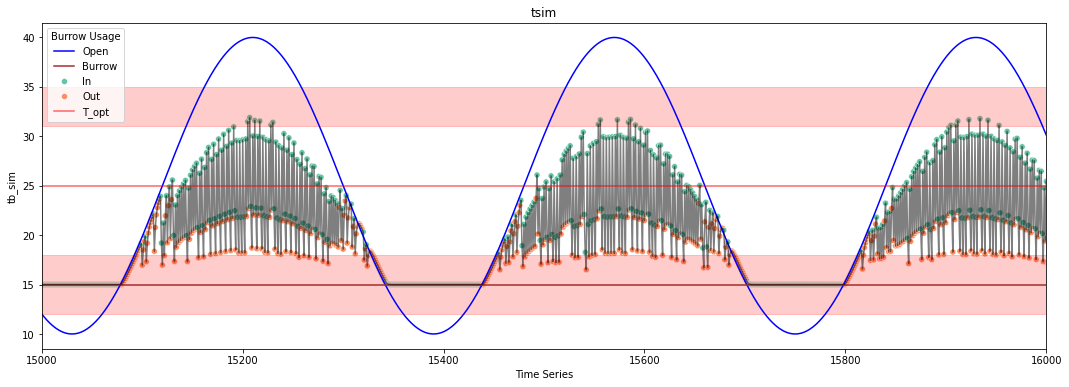

In [49]:
plt.figure(figsize=(18, 6))

sns.lineplot(data=df, x='time_steps', y='open_temp', label = 'Open', color="blue")
sns.lineplot(data=df, x='time_steps', y='burrow_temp', label = 'Burrow', color = "brown")
sns.lineplot(data=df, x='time_steps', y='tb_sim', color="black", alpha=0.5)
sns.scatterplot(data=df, x='time_steps', y='tb_sim', hue='burrow_usage', palette='Set2')

# upper crit limit
plt.axhspan(31, 35, color='red', alpha=0.2)
# lower crit limit
plt.axhspan(12, 18, color='red', alpha=0.2)

plt.axhline(25, color='red', alpha=0.6, label='T_opt')

#plt.xlim(0,100)
plt.xlim(15000,16000)
#plt.ylim(15,35)
plt.xlabel('Time Series')
plt.ylabel('tb_sim')
plt.title('tsim')


plt.legend(title='Burrow Usage', loc='upper left')


plt.show()

In [36]:
### State flips
def state_flips(values):
    result = [0]  # The first value always has no previous value to compare
    for i in range(1, len(values)):
        if values[i] != values[i - 1]:
            result.append(1)
        else:
            result.append(0)
    return result


df['State_Flips'] = state_flips(df['burrow_usage'])
rolling_sum = df['State_Flips'].rolling(window=250).sum()

# Add the rolling sum as a new column to the DataFrame
df['Rolling_Sum'] = rolling_sum

<Axes: xlabel='time_steps', ylabel='Rolling_Sum'>

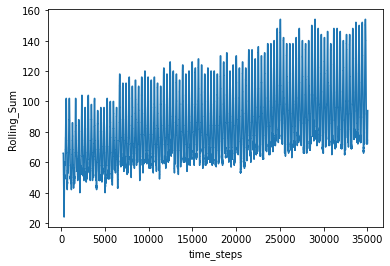

In [37]:
sns.lineplot(data=df, x='time_steps', y='Rolling_Sum')
#plt.xlim(11000,13000)

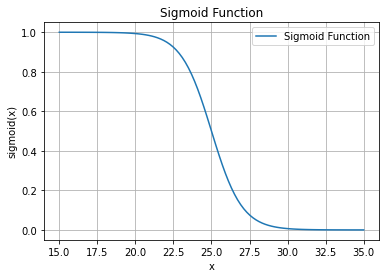

In [15]:
def sigmoid(t_body):
    return 1 / (1 + np.exp(-(25-t_body)))

# Generate values for x
#t_opt_vals = np.linspace(25, 25, 100)
t_body_values = np.linspace(15, 35, 100)

# Calculate the sigmoid values
sigmoid_values = sigmoid(t_body_values)

# Plot the sigmoid function
plt.plot(t_body_values, sigmoid_values, label='Sigmoid Function')
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.legend()
plt.grid(True)
plt.show()

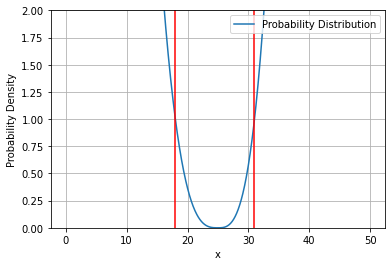

In [55]:
def preferred_topt(t_body, t_pref_opt, t_pref_max, t_pref_min):
    if t_body >= t_pref_opt:
        prob_flip =  ((t_body - t_pref_opt) / (t_pref_max - t_pref_opt))**3
    elif t_body < t_pref_opt:
        prob_flip =  ((t_pref_opt - t_body) / (t_pref_opt - t_pref_min))**3
    return prob_flip 

# Set the mode and range
t_opt = 25
t_pref_max = 31 
t_pref_min = 18 

# Create a triangular distribution
t_body_values = np.linspace(0, 50, 1000)
probs = [preferred_topt(t_body = t_body, t_pref_opt=t_opt, t_pref_max = t_pref_max, t_pref_min = t_pref_min) for t_body in t_body_values]

# Plot the triangular distribution
plt.plot(t_body_values, probs, label='Probability Distribution')
plt.axvline(t_pref_min, color='r')
plt.axvline(t_pref_max, color='r')
plt.ylim(0,2)
plt.title('')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()